<a href="https://colab.research.google.com/github/SergeyPishchulov/CurrencyConverter/blob/main/Logica_Final_Exam_by_%D0%A1%D0%B5%D1%80%D0%B3%D0%B5%D0%B9_%D0%9F%D0%B8%D1%89%D1%83%D0%BB%D0%BE%D0%B2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logic Programming for Data Analysis 2021: Final Exam

`Сергей Пищулов`

`spishulov@gmail.com`

Original data sources:
* https://www.kaggle.com/kenshoresearch/kensho-derived-wikimedia-data
* https://www.kaggle.com/wosaku/crime-in-vancouver


In [1]:
!git clone https://github.com/evgskv/logica
from logica import colab_logica

Cloning into 'logica'...
remote: Enumerating objects: 1610, done.
remote: Counting objects: 100% (802/802), done.
remote: Compressing objects: 100% (554/554), done.
remote: Total 1610 (delta 493), reused 380 (delta 226), pack-reused 808
Receiving objects: 100% (1610/1610), 3.87 MiB | 12.61 MiB/s, done.
Resolving deltas: 100% (932/932), done.


In [17]:
%load_ext google.colab.data_table

In [2]:
!gdown https://drive.google.com/uc?id=1sPVUx7LzqofzvEdcB-9JUX4qlrqW7gbe
!unzip showbiz_and_vancouver.zip

Downloading...
From: https://drive.google.com/uc?id=1sPVUx7LzqofzvEdcB-9JUX4qlrqW7gbe
To: /content/showbiz_and_vancouver.zip
100% 25.3M/25.3M [00:00<00:00, 26.1MB/s]
Archive:  showbiz_and_vancouver.zip
  inflating: showbusiness.db         
  inflating: vancouver_crime.db      


In [64]:
%%logica SomeMovies, SomePeople, SomeRockBands, SomeAwards, ShowbusinessStats, PathFromVladimirToArnold, PathFromLyudmilaToMarilyn


@Engine("sqlite");
@AttachDatabase("db", "showbusiness.db");

@Limit(SomeMovies, 10);
SomeMovies(..r) :- db.movie(..r);

@Limit(SomePeople, 10);
SomePeople(..r) :- db.person(..r);

@Limit(SomeRockBands, 10);
SomeRockBands(..r) :- db.rockband(..r);

@Limit(SomeAwards, 10);
SomeAwards(..r) :- db.award(..r);

ShowbusinessStats(num_movies:,
                  num_people:,
                  num_bands:) :-
  num_movies += (1 :- db.movie()),
  num_people += (1 :- db.person()),
  num_bands += (1 :- db.rockband());

#TODO Проверить на всех non-distinct предикатах, влияет ли на них distinct.
#TODO вызвать все предикаты.

#1
LordOfRock(person_id:, person_name:) distinct :- 
  db.award(awardee_id:person_id, awardee_name:person_name, award:"Order of the British Empire"),
  db.award(awardee_id:person_id, awardee_name:person_name, award:"Rock and Roll Hall of Fame");

#2
JuniorOrderMember(person_id:, person_name:) distinct :-
  db.award(awardee_id:person_id, awardee_name:person_name, award:"Order of the British Empire"),
  ~db.award(awardee_id:person_id, awardee_name:person_name, award:"Commander of the Order of the British Empire");

#3 TODO
ProminentSovietArtist(person_id:, person_name:) distinct :- 
  db.award(awardee_id:person_id, awardee_name:person_name, award:"USSR State Prize") | 
  db.award(awardee_id:person_id, awardee_name:person_name, award:"People's Artist of the USSR");

#4
BillAndCharlieButNotKevin(award:) distinct :- 
  db.award(awardee_name:"Bill Gates", award:),
  db.award(awardee_name:"Charlie Chaplin", award:),
  ~db.award(awardee_name:"Kevin Spacey", award:);

#5
RussianRockArtist(person_id:, person_name:) :- db.person(person_id:, name:person_name, citizenships:),
  "Russia" in citizenships, RockArtist(person_id:);

@Ground(RockArtist); 
RockArtist(person_id:) distinct :- db.rockband(members:), person_id in members;

#6 TODO пустые списки, чтобы в этой таблице были все группы
# RockBandMovies(rockband_id:, rockband_name:, movies? Set=movie_name) distinct :-
#   db.rockband(band_id:rockband_id, name:rockband_name, members:),
#   member in members, 
#   movie_name in MoviesByPerson(person_id:member);

# @Ground(PersonInMovie); 
# MoviesByPerson(person_id:) List= movie_name distinct:- 
#   db.movie(name:movie_name, casting:), person_id in casting | RockArtist(person_id:);

#7
Medalist(person_name:, person_id:, number_of_awards:, awards:, social_circle_awards:) distinct :-
  MedalistPartial(person_name:, person_id:, awards:, social_circle_awards:),
  number_of_awards == Size(awards),
  number_of_awards > 5;

@Ground(MedalistPartial); 
MedalistPartial(person_name:, person_id:, awards? List= award, social_circle_awards:) distinct :-
  db.person(person_id:, name:person_name),
  db.award(awardee_id:person_id, award:),
  SocialCircleAwards(person_id:, friends_awards:social_circle_awards);


@Ground(SocialCircleAwards); 
SocialCircleAwards(person_id:, friends_awards? Set= friend_award) distinct :-
  Circle(person1_id:person_id, person2_id:friend_id),
  db.award(awardee_id:friend_id, award:friend_award);

@Ground(Circle); 
Circle(person1_id:, person2_id:) :- db.movie(casting:),
  person1_id in casting, 
  person2_id  in casting,
  person1_id != person2_id;
Circle(person1_id:, person2_id:) :- db.rockband(members:),
  person1_id in members, 
  person2_id  in members,
  person1_id != person2_id;

Flatten(list_of_lists) = r :- r List= x, x in xs, xs in list_of_lists;
Unique(l) = r :- r Set= x, x in l;


#9 TODO записей примерно на 1000 меньше чем фильмов. Кажется, не все актеры есть в persons
@Ground(CitizenshipsInMovies); 
CitizenshipsInMovies(movie_id:, movie_name:, citizenships? Set= x) distinct :-
  db.movie(movie_id:, name:movie_name, casting:),
  person_id in casting,
  person(person_id:, citizenships:person_citizenships),
  all_persons_citizenships List= person_citizenships,
  x in Flatten(all_persons_citizenships);

AukusMovie(movie_id:, movie_name:, citizenships:) :-
  CitizenshipsInMovies(movie_id:, movie_name:, citizenships:),
  "Australia" in citizenships,
  "United Kingdom" in citizenships,
  "United States of America" in citizenships;

#10
@Ground(CastTogether); 
CastTogether(x, y, movie:name) :- db.movie(casting:, name:),
  x in casting, 
  y  in casting,
  x != y;
@Ground(VysotskyId); 
VysotskyId() = person_id :- db.person(person_id:, name:"Vladimir Vysotsky");
@Ground(SchwarzeneggerId);
SchwarzeneggerId() = person_id :- db.person(person_id:, name:"Arnold Schwarzenegger");

@Ground(PathTo); 
@Recursive(PathTo, 3);
PathTo(VysotskyId()) ArgMin= [{person_id:VysotskyId(), movie_to_person:1000}] -> 0;

PathTo(y) ArgMin= path -> Size(path) :-
 PathTo(x) == path_to_x,
 CastTogether(x, y, movie:movie_to_y),
 path == ArrayConcat(path_to_x, [{person_id:y, movie_to_person:movie_to_y}]);

#TODO Если бы 2 актера снимались в двух фильмах, то оба фильма бы попали в таблицу с одним и тем же step_number
@Ground(OnlyPath); 
OnlyPath() =  PathTo(SchwarzeneggerId());
PathFromVladimirToArnold(step_number:i+1, from_person:, to_person:, movie:movie_to_to) :-
  i in Range(Size(path) - 1),
  {person_id:from_person_id} == Element(path, i),
  {person_id:to_person_id, movie_to_person:movie_to_to} == Element(path, i+1),
  to_person_id == Element(path, i+1),
  path == OnlyPath(),
  db.person(person_id:from_person_id, name:from_person),
  db.person(person_id:to_person_id, name:to_person);


@Ground(GurchenkoId); 
GurchenkoId() = person_id :- db.person(person_id:, name:"Lyudmila Gurchenko");
@Ground(MonroeId);
MonroeId() = person_id :- db.person(person_id:, name:"Marilyn Monroe");

PathFromLyudmilaToMarilyn := PathFromVladimirToArnold(VysotskyId:GurchenkoId, SchwarzeneggerId: MonroeId );


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SomeMovies_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  db_movie.*
FROM
  db.movie AS db_movie LIMIT 10;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SomePeople_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  db_person.*
FROM
  db.person AS db_person LIMIT 10;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SomeRockBands_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  db_rockband.*
FROM
  db.rockband AS db_rockband LIMIT 10;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SomeAwards_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  db_award.*
FROM
  db.award AS db_award LIMIT 10;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at ShowbusinessStats_sql variable.
ATTACH DATABASE 'showbusiness.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  (SELECT
  SUM(MagicalEntangle(1, x_4.value)) AS logica_value
FROM
  db.movie AS db_movie, JSON_EACH(JSON_ARRAY(0)) as x_4) AS num_movies,
  (SELECT
  SUM(MagicalEntangle(1, x_6.value)) AS logica_value
FROM
  db.person AS db_person, JSON_EACH(JSON_ARRAY(0)) as x_6) AS num_people,
  (SELECT
  SUM(MagicalEntangle(1, x_8.value)) AS logica_value
FROM
  db.rockband AS db_rockband, JSON_EACH(JSON_ARRAY(0)) as x_8) AS num_bands;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encountered error when compiling PathFromVladimirToArnold.


Compiling:
PathFromVladimirToArnold(step_number:i+1, from_person:, to_person:, movie:movie_to_to) :-
  i in Range(Size(path) - 1),
  {person_id:from_person_id} == Element(path, i),
  {person_id:to_person_id, movie_to_person:movie_to_to} == Element(path, i+1),
  to_person_id == Element(path, i+1),
  path == OnlyPath(),
  db.person(person_id:from_person_id, name:from_person),
  db.person(person_id:to_person_id, name:to_person)

[ Error ] Found no way to assign variables: movie_to_to. This error might also come from injected sub-rules.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at SomeCrime_sql variable.
ATTACH DATABASE 'vancouver_crime.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  db_crime.*
FROM
  db.crime AS db_crime LIMIT 10;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at NumCrimes_sql variable.
ATTACH DATABASE 'vancouver_crime.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  SUM(1) AS logica_value
FROM
  db.crime AS db_crime;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at CrimeCountAtHour_sql variable.
ATTACH DATABASE 'vancouver_crime.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

SELECT
  db_crime.hour AS hour,
  db_crime.crimetype AS crimetype,
  SUM(1) AS count
FROM
  db.crime AS db_crime
GROUP BY db_crime.hour, db_crime.crimetype;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at CrimeAtHour_sql variable.
ATTACH DATABASE 'vancouver_crime.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

WITH t_1_CrimeCountAtHour AS (SELECT
  db_crime.hour AS hour,
  db_crime.crimetype AS crimetype,
  SUM(1) AS count
FROM
  db.crime AS db_crime
GROUP BY db_crime.hour, db_crime.crimetype)
SELECT
  CrimeCountAtHour.hour AS hour,
  JSON_EXTRACT(ArgMax(CrimeCountAtHour.crimetype, CrimeCountAtHour.count, 1), '$[' || 0 || ']') AS crimetype
FROM
  t_1_CrimeCountAtHour AS CrimeCountAtHour
GROUP BY CrimeCountAtHour.hour;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at NeighbourhoodCrimeDistribution_sql variable.
ATTACH DATABASE 'vancouver_crime.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.AllCrimesCountInNeighbourhood;
CREATE TABLE logica_test.AllCrimesCountInNeighbourhood AS WITH t_0_CrimesCountInNeighbourhood AS (SELECT
  db_crime.neighbourhood AS neighbourhood,
  db_crime.crimetype AS crimetype,
  SUM(1) AS logica_value
FROM
  db.crime AS db_crime
GROUP BY db_crime.neighbourhood, db_crime.crimetype)
SELECT
  t_1_CrimesCountInNeighbourhood.neighbourhood AS neighbourhood,
  SUM(t_1_CrimesCountInNeighbourhood.logica_value) AS logica_value
FROM
  t_0_CrimesCountInNeighbourhood AS t_1_CrimesCountInNeighbourhood
GROUP BY t_1_CrimesCountInNeighbourhood.neighbourhood;

-- Interacting with table logica_test.AllCrimesCountInNeighbourhood

WITH t_0_CrimesCountInNeighbourhood AS (SELECT
  db_crime.neighbourhood AS neighbourhood,
  db_crime.crimetype AS crimetype,
  SUM(1) AS logica_v

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at CrimeChangeExpanded_sql variable.
ATTACH DATABASE 'vancouver_crime.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.CrimeCountByYear;
CREATE TABLE logica_test.CrimeCountByYear AS SELECT
  db_crime.year AS year,
  db_crime.crimetype AS crimetype,
  SUM(1) AS logica_value
FROM
  db.crime AS db_crime
GROUP BY db_crime.year, db_crime.crimetype;

-- Interacting with table logica_test.CrimeCountByYear

SELECT
  CrimeCountByYear.year AS year,
  CrimeCountByYear.crimetype AS crimetype,
  t_0_CrimeCountByYear.logica_value AS changed_from,
  CrimeCountByYear.logica_value AS changed_to,
  ABS(((CrimeCountByYear.logica_value) - (t_0_CrimeCountByYear.logica_value))) AS delta
FROM
  logica_test.CrimeCountByYear AS CrimeCountByYear, logica_test.CrimeCountByYear AS t_0_CrimeCountByYear
WHERE
  (t_0_CrimeCountByYear.year = ((CrimeCountByYear.year) - (1))) AND
  (t_0_CrimeCountByYear.crimetype = CrimeCountByYear.crimetype);


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at MostVolatileType_sql variable.
ATTACH DATABASE 'vancouver_crime.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.CrimeCountByYear;
CREATE TABLE logica_test.CrimeCountByYear AS SELECT
  db_crime.year AS year,
  db_crime.crimetype AS crimetype,
  SUM(1) AS logica_value
FROM
  db.crime AS db_crime
GROUP BY db_crime.year, db_crime.crimetype;

-- Interacting with table logica_test.CrimeCountByYear

SELECT
  CrimeCountByYear.year AS year,
  JSON_EXTRACT(ArgMax(CrimeCountByYear.crimetype, ABS(((CrimeCountByYear.logica_value) - (t_1_CrimeCountByYear.logica_value))), 1), '$[' || 0 || ']') AS crimetype
FROM
  logica_test.CrimeCountByYear AS CrimeCountByYear, logica_test.CrimeCountByYear AS t_1_CrimeCountByYear
WHERE
  (t_1_CrimeCountByYear.year = ((CrimeCountByYear.year) - (1))) AND
  (t_1_CrimeCountByYear.crimetype = CrimeCountByYear.crimetype)
GROUP BY CrimeCountByYear.year;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at CrimeChange_sql variable.
ATTACH DATABASE 'vancouver_crime.db' AS db;
ATTACH DATABASE ':memory:' AS logica_test;

DROP TABLE IF EXISTS logica_test.CrimeCountByYear;
CREATE TABLE logica_test.CrimeCountByYear AS SELECT
  db_crime.year AS year,
  db_crime.crimetype AS crimetype,
  SUM(1) AS logica_value
FROM
  db.crime AS db_crime
GROUP BY db_crime.year, db_crime.crimetype;

-- Interacting with table logica_test.CrimeCountByYear

WITH t_1_MostVolatileType AS (SELECT
  t_4_CrimeCountByYear.year AS year,
  JSON_EXTRACT(ArgMax(t_4_CrimeCountByYear.crimetype, ABS(((t_4_CrimeCountByYear.logica_value) - (t_5_CrimeCountByYear.logica_value))), 1), '$[' || 0 || ']') AS crimetype
FROM
  logica_test.CrimeCountByYear AS t_4_CrimeCountByYear, logica_test.CrimeCountByYear AS t_5_CrimeCountByYear
WHERE
  (t_5_CrimeCountByYear.year = ((t_4_CrimeCountByYear.year) - (1))) AND
  (t_5_CrimeCountByYear.crimetype = t_4_CrimeCountByYear.crimetype)
GROUP BY t_4_CrimeCountByYear.y

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

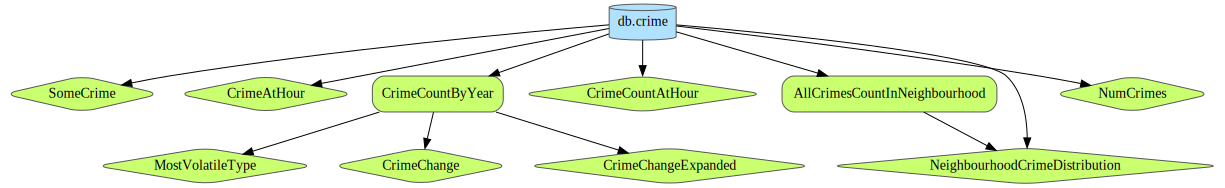

Running predicate: CrimeCountAtHour (1 seconds)
Running predicate: AllCrimesCountInNeighbourhood (0 seconds)
Running predicate: NeighbourhoodCrimeDistribution (1 seconds)
Running predicate: CrimeCountByYear (0 seconds)
Running predicate: NumCrimes (0 seconds)
Running predicate: SomeCrime (0 seconds)
Running predicate: CrimeAtHour (1 seconds)
Running predicate: MostVolatileType (0 seconds)
Running predicate: CrimeChange (0 seconds)
Running predicate: CrimeChangeExpanded (0 seconds)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at SomeCrime variable.


,crimetype,year,month,day,hour,minute,hundred_block,neighbourhood,x,y,latitude,longitude
0,Other Theft,2003,5,12,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
1,Other Theft,2003,5,7,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
2,Other Theft,2003,4,23,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
3,Other Theft,2003,4,20,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
4,Other Theft,2003,4,12,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
5,Other Theft,2003,3,26,20.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
6,Break and Enter Residential/Other,2003,3,10,12.0,0.0,63XX WILTSHIRE ST,Kerrisdale,489325.58,5452817.95,49.228051,-123.146610
7,Mischief,2003,6,28,4.0,13.0,40XX W 19TH AVE,Dunbar-Southlands,485903.09,5455883.77,49.255559,-123.193725
8,Other Theft,2003,2,16,9.0,2.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
9,Break and Enter Residential/Other,2003,7,9,18.0,15.0,18XX E 3RD AVE,Grandview-Woodland,495078.19,5457221.38,49.267734,-123.067654


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at NumCrimes variable.


,logica_value
0,530652


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at CrimeCountAtHour variable.


,hour,crimetype,count
0,NaN,Homicide,220
1,NaN,Offence Against a Person,54142
2,0.0,Break and Enter Commercial,2326
3,0.0,Break and Enter Residential/Other,3049
4,0.0,Mischief,5616
...,...,...,...
213,23.0,Theft from Vehicle,10602
214,23.0,Theft of Bicycle,971
215,23.0,Theft of Vehicle,2912
216,23.0,Vehicle Collision or Pedestrian Struck (with F...,10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at CrimeAtHour variable.


,hour,crimetype
0,NaN,Offence Against a Person
1,0.0,Theft from Vehicle
2,1.0,Theft from Vehicle
3,2.0,Mischief
4,3.0,Break and Enter Commercial
5,4.0,Break and Enter Commercial
6,5.0,Break and Enter Commercial
7,6.0,Theft from Vehicle
8,7.0,Theft from Vehicle
9,8.0,Theft from Vehicle


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at NeighbourhoodCrimeDistribution variable.


,neighbourhood,crimes
0,Arbutus Ridge,"[{""crimetype"":""Break and Enter Commercial"",""pr..."
1,Central Business District,"[{""crimetype"":""Break and Enter Commercial"",""pr..."
2,Dunbar-Southlands,"[{""crimetype"":""Break and Enter Commercial"",""pr..."
3,Fairview,"[{""crimetype"":""Break and Enter Commercial"",""pr..."
4,Grandview-Woodland,"[{""crimetype"":""Break and Enter Commercial"",""pr..."
5,Hastings-Sunrise,"[{""crimetype"":""Break and Enter Commercial"",""pr..."
6,Kensington-Cedar Cottage,"[{""crimetype"":""Break and Enter Commercial"",""pr..."
7,Kerrisdale,"[{""crimetype"":""Break and Enter Commercial"",""pr..."
8,Killarney,"[{""crimetype"":""Break and Enter Commercial"",""pr..."
9,Kitsilano,"[{""crimetype"":""Break and Enter Commercial"",""pr..."


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at CrimeChangeExpanded variable.


,year,crimetype,changed_from,changed_to,delta
0,2004,Break and Enter Commercial,3197,3283,86
1,2004,Break and Enter Residential/Other,6883,6538,345
2,2004,Homicide,18,22,4
3,2004,Mischief,6391,5601,790
4,2004,Offence Against a Person,3507,3804,297
...,...,...,...,...,...
149,2017,Theft from Vehicle,12806,5962,6844
150,2017,Theft of Bicycle,2634,986,1648
151,2017,Theft of Vehicle,1474,755,719
152,2017,Vehicle Collision or Pedestrian Struck (with F...,15,5,10


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at MostVolatileType variable.


,year,crimetype
0,2004,Mischief
1,2005,Theft from Vehicle
2,2006,Theft from Vehicle
3,2007,Theft from Vehicle
4,2008,Theft from Vehicle
5,2009,Theft from Vehicle
6,2010,Theft from Vehicle
7,2011,Theft from Vehicle
8,2012,Theft from Vehicle
9,2013,Break and Enter Residential/Other


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at CrimeChange variable.


,year,crimetype,changed_from,changed_to
0,2004,Mischief,6391,5601
1,2005,Theft from Vehicle,18204,16554
2,2006,Theft from Vehicle,16554,14734
3,2007,Theft from Vehicle,14734,12226
4,2008,Theft from Vehicle,12226,11298
5,2009,Theft from Vehicle,11298,10007
6,2010,Theft from Vehicle,10007,8612
7,2011,Theft from Vehicle,8612,7435
8,2012,Theft from Vehicle,7435,8097
9,2013,Break and Enter Residential/Other,3311,3025


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
%%logica SomeCrime, NumCrimes, CrimeCountAtHour, CrimeAtHour, NeighbourhoodCrimeDistribution, CrimeChangeExpanded, MostVolatileType, CrimeChange

@Engine("sqlite");
@AttachDatabase("db", "vancouver_crime.db");

@Limit(SomeCrime, 10);
SomeCrime(..r) :- db.crime(..r);

NumCrimes() += 1 :- db.crime();

#11
CrimeAtHour(hour:, crimetype? ArgMax= crimetype -> count ) distinct :- CrimeCountAtHour(hour:, crimetype:, count:);

CrimeCountAtHour(hour:, crimetype:, count? +=1) distinct :- db.crime(hour:, crimetype:);

#12
NeighbourhoodCrimeDistribution(neighbourhood:, crimes? List= {crimetype:, proportion:}) distinct :-
  proportion == CrimetypeProportionInNeighbourhood(neighbourhood:, crimetype:);

CrimetypeProportionInNeighbourhood(neighbourhood:, crimetype:) = ToFloat64(count)/all_crimes_in_nei :-
  count == CrimesCountInNeighbourhood(neighbourhood:, crimetype:),
  all_crimes_in_nei == AllCrimesCountInNeighbourhood(neighbourhood:);

CrimesCountInNeighbourhood(neighbourhood:, crimetype:) +=1 :- db.crime(neighbourhood:, crimetype:);

@Ground(AllCrimesCountInNeighbourhood);
AllCrimesCountInNeighbourhood(neighbourhood:) += CrimesCountInNeighbourhood(neighbourhood:, crimetype:);

#TODO delete
CheckPerc(neighbourhood:, r? += proportion) distinct :- 
  proportion == CrimetypeProportionInNeighbourhood(neighbourhood:, crimetype:);

  
Abs(x) = if x > 0 then x else -1*x;
#13
CrimeChange(year:, crimetype:, changed_from:, changed_to:) :- 
  MostVolatileType(year:, crimetype:),
  CrimeChangeExpanded(year:, crimetype:, changed_from:, changed_to:);

MostVolatileType(year:, crimetype? ArgMax= ct -> delta) distinct :- 
  CrimeChangeExpanded(year:, crimetype:ct, changed_from:, changed_to:, delta:);

CrimeChangeExpanded(year:this_year, crimetype:, changed_from:prev_count, changed_to:cur_count, delta:):-
  cur_count == CrimeCountByYear(year:this_year, crimetype:),
  prev_count == CrimeCountByYear(year:this_year - 1, crimetype:),
  delta == Abs(cur_count - prev_count);

@Ground(CrimeCountByYear);
CrimeCountByYear(year:, crimetype:) += 1 :- db.crime(year:, crimetype:);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at Fibonacci_sql variable.
WITH t_15_Fibonacci_r0 AS (SELECT * FROM (
  
    SELECT
      0 AS number_index,
      0 AS number_value
   UNION ALL
  
    SELECT
      1 AS number_index,
      1 AS number_value
  
) AS UNUSED_TABLE_NAME  ),
t_13_Fibonacci_r1 AS (SELECT * FROM (
  
    SELECT
      0 AS number_index,
      0 AS number_value
   UNION ALL
  
    SELECT
      1 AS number_index,
      1 AS number_value
   UNION ALL
  
    SELECT
      x_47.value AS number_index,
      ((Fibonacci_r0.number_value) + (t_14_Fibonacci_r0.number_value)) AS number_value
    FROM
      t_15_Fibonacci_r0 AS Fibonacci_r0, t_15_Fibonacci_r0 AS t_14_Fibonacci_r0, JSON_EACH((select json_group_array(n) from (with recursive t as(select 0 as n union all select n + 1 as n from t where n + 1 < 10) select n from t) where n < 10)) as x_47
    WHERE
      (x_47.value > 1) AND
      (Fibonacci_r0.number_index = ((x_47.value) - (1))) AND
      (t_14_Fibonacci_r0.number_index = ((x_47.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

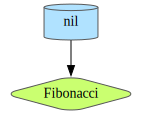

Running predicate: Fibonacci (0 seconds)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at Fibonacci variable.


,number_index,number_value
0,0,0
1,1,1
2,2,1
3,3,2
4,4,3
5,5,5
6,6,8
7,7,13
8,8,21
9,9,34


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
%%logica Fibonacci

@Engine("sqlite");

#14
Fibonacci(number_index:0, number_value:0);
Fibonacci(number_index:1, number_value:1);

Fibonacci(number_index:, number_value:prev+prev_prev) :- 
  Fibonacci(number_index:number_index-1, number_value:prev),
  Fibonacci(number_index:number_index-2, number_value:prev_prev),
  number_index in Range(10),
  number_index > 1;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following query is stored at Word_sql variable.
SELECT * FROM (
  
    SELECT
      '20211212' AS col0
   UNION ALL
  
    SELECT
      'neveragain' AS col0
   UNION ALL
  
    SELECT
      'civil' AS col0
   UNION ALL
  
    SELECT
      'abbaforever' AS col0
   UNION ALL
  
    SELECT
      'taxxataxxazere' AS col0
  
) AS UNUSED_TABLE_NAME  ;


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

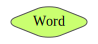

Running predicate: Word (0 seconds)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following table is stored at Word variable.


,col0
0,20211212
1,neveragain
2,civil
3,abbaforever
4,taxxataxxazere


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
%%logica Word

@Engine("sqlite");
Word("20211212");
Word("neveragain");
Word("civil");
Word("abbaforever");
Word("taxxataxxazere");
